In [2]:
import os
os.chdir("/projects/crispy_shifty")

from crispy_shifty.utils.io import gen_array_tasks

design_list_file = os.path.join(os.getcwd(), "projects/DAB/02_mpnn_structure/mpnn_inpaints.pair")

simulation_name = "03_fold_complex"
output_path = os.path.join(os.getcwd(), f"projects/DAB/{simulation_name}")

options = " ".join(
    [
        "out:level 100",
    ]
)
extra_kwargs = {
    "models": "1", 
    "use_filter": "false", 
    "use_initial_guess": "true",
    "rank_on": "false"
}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.folding.fold_bound_state",
    design_list_file=design_list_file,
    output_path=output_path,
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
    queue="gpu",
    time="02:00:00",
    gres="--gres=gpu:a4000:1"
)

Run the following command with your desired environment active:
sbatch -a 1-1800 /home/broerman/crispy_shifty/projects/DAB/round_2/design/03_fold_complex/run.sh


Folding all models will take a week on the digs, filter first with model 1 instead

In [1]:
import os
os.chdir("/projects/crispy_shifty")

simulation_name = "03_fold_complex"
output_path = os.path.join(os.getcwd(), f"projects/DAB/{simulation_name}")

In [2]:
from crispy_shifty.utils.io import collect_score_file

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

In [3]:
from crispy_shifty.utils.io import parse_scorefile_linear

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

  0%|          | 0/117059 [00:00<?, ?it/s]

This is a bit more than I am supposed to have. Likely there are some duplicates.

In [4]:
import numpy as np
scores_df["designed_by"] = np.where(scores_df["designed_by"] == "mpnn", "mpnn", "inpainting")
reindex_cols = ['mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'model', 'pTMscore', 'recycles', 'rmsd_to_reference', 'seed', 'tol']
scores_df.rename({col: f"Y_{col}" for col in reindex_cols}, axis=1, inplace=True)

In [5]:
import pandas as pd

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col=0)

5it [00:01,  4.95it/s]


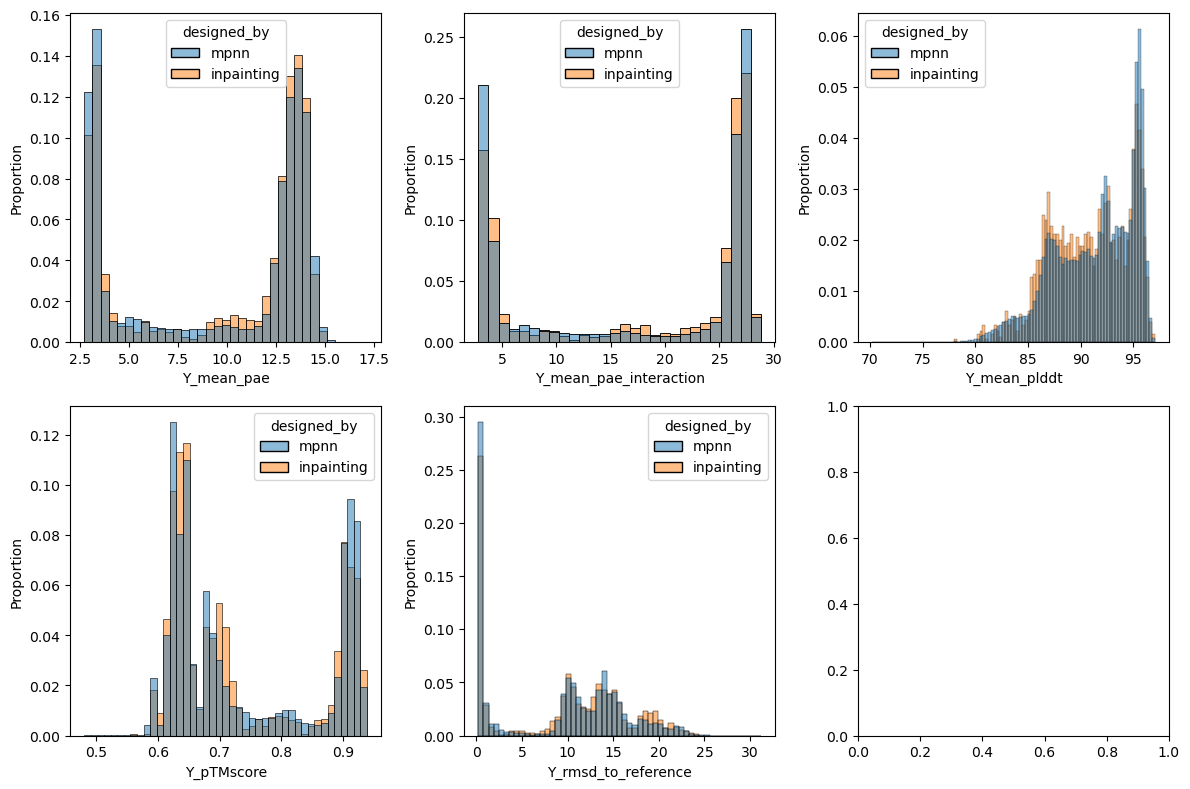

In [7]:
import matplotlib.pyplot as plt
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

cols = [
    "Y_mean_pae",
    "Y_mean_pae_interaction",
    "Y_mean_plddt",
    "Y_pTMscore",
    "Y_rmsd_to_reference",
]
the_fig = histplot_df(
    df=scores_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
)
plt.savefig(os.path.join(output_path, "af2_scores_all.png"))

In [32]:
filtered_df = scores_df.query("Y_rmsd_to_reference < 2 and (Y_mean_pae_interaction < 5 or (parent == 'JHB_07ABr2' and Y_mean_pae_interaction < 10)) and Y_mean_plddt > 90")

In [33]:
filtered_df.parent.value_counts().sort_index()

JHB_07ABr2           16
cs_201r1             60
cs_203r2           4062
cs_207_left         950
cs_207_right1      6222
cs_207_right2      5835
cs_221             1687
cs_230_straight     272
cs_230_twist         28
cs_242              130
cs_243              926
cs_244_straight     120
cs_244_twist         98
cs_245               28
cs_269_straight    5529
cs_269_twist       4628
cs_287              641
cs_292             3743
Name: parent, dtype: int64

5it [00:01,  4.76it/s]


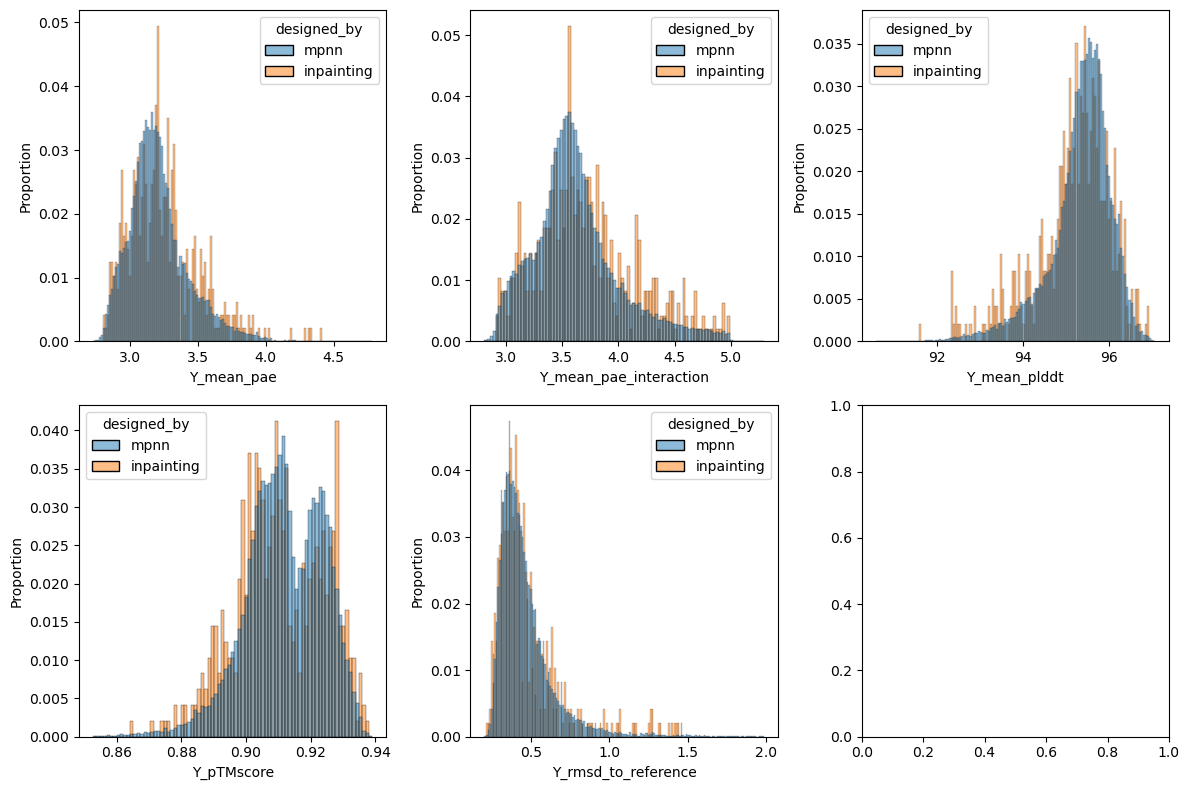

In [34]:
the_fig = histplot_df(
    df=filtered_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
)
plt.savefig(os.path.join(output_path, "af2_scores.png"))

In [37]:
filtering_cols = [
    ("Y_mean_plddt", False),
    ("Y_mean_pae", True),
    ("Y_mean_pae_interaction", True),
]

# choose the top 5%
target_representation = 320

all_parents = set(filtered_df.parent.values)
parent_dfs = []
for parent in all_parents:
    parent_df = filtered_df[filtered_df.parent == parent]

    if len(parent_df) > target_representation:
        # find the 10 designs which have all filtering metrics above the quantile cutoff
        filtering_df = pd.DataFrame(columns=[col for col, _ in filtering_cols])
        for col, minimize in filtering_cols:
            if minimize:
                filtering_df[col] = -parent_df[col]
            else:
                filtering_df[col] = parent_df[col]

        filtered_quantile_df = filtering_df
        df_len = len(filtered_quantile_df)
        q = 0.5
        min_q = 0
        max_q = 1
        n_iter = 0
        while df_len != target_representation:
            filtered_quantile_df = filtering_df[filtering_df > filtering_df.quantile(q)].dropna()
            df_len = len(filtered_quantile_df)
            if n_iter > 100:
                # if it's impossible to distinguish among designs, just take the best by plddt
                filtered_quantile_df = filtering_df[filtering_df > filtering_df.quantile(min_q)].dropna().sort_values(by="Y_mean_plddt", ascending=False).head(target_representation)
                print(f"iteration limit reached for inpaint id {parent} with {df_len} designs at quantile {q}, min_q {min_q}, max_q {max_q}")
                break
            if df_len < target_representation:
                max_q = q
                q = (max_q + min_q) / 2
            elif df_len > target_representation:
                min_q = q
                q = (max_q + min_q) / 2
            n_iter += 1
        
        parent_df = parent_df.loc[filtered_quantile_df.index, :]

    parent_dfs.append(parent_df)

filtered_df = pd.concat(parent_dfs)

In [38]:
filtered_df.parent.value_counts().sort_index()

JHB_07ABr2          16
cs_201r1            60
cs_203r2           320
cs_207_left        320
cs_207_right1      320
cs_207_right2      320
cs_221             320
cs_230_straight    272
cs_230_twist        28
cs_242             130
cs_243             320
cs_244_straight    120
cs_244_twist        98
cs_245              28
cs_269_straight    320
cs_269_twist       320
cs_287             320
cs_292             320
Name: parent, dtype: int64

In [39]:
with open(os.path.join(output_path, "folded_structures.list"), "w") as f:
    for path in filtered_df.index:
        print(path, file=f)

Now fold the best 5% by model 1 with all models

In [41]:
import os
os.chdir("/projects/crispy_shifty")

from crispy_shifty.utils.io import gen_array_tasks

design_list_file = os.path.join(os.getcwd(), "projects/DAB/03_fold_complex/folded_structures.list")

simulation_name = "03_fold_complex_all"
output_path = os.path.join(os.getcwd(), f"projects/DAB/{simulation_name}")

options = " ".join(
    [
        "out:level 100",
    ]
)
extra_kwargs = {
    "models": "all", 
    "use_initial_guess": "true",
}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.folding.fold_general",
    design_list_file=design_list_file,
    output_path=output_path,
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
    queue="gpu",
    time="00:20:00",
    gres="--gres=gpu:a4000:1"
)

Run the following command with your desired environment active:
sbatch -a 1-3952 /home/broerman/crispy_shifty/projects/DAB/round_2/design/03_fold_complex_all/run.sh


In [1]:
import os
os.chdir("/projects/crispy_shifty")

simulation_name = "03_fold_complex_all"
output_path = os.path.join(os.getcwd(), f"projects/DAB/{simulation_name}")

In [2]:
from crispy_shifty.utils.io import collect_score_file

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

In [3]:
from crispy_shifty.utils.io import parse_scorefile_linear

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

  0%|          | 0/19750 [00:00<?, ?it/s]

In [10]:
import numpy as np
scores_df["designed_by"] = np.where(scores_df["designed_by"] == "mpnn", "mpnn", "inpainting")
reindex_cols = ['mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'model', 'pTMscore', 'recycles', 'rmsd_to_best', 'rmsd_to_input', 'rmsd_to_reference', 'seed', 'tol']
scores_df.rename({col: f"Y_{col}" for col in reindex_cols}, axis=1, inplace=True)

In [2]:
import pandas as pd

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col=0)

6it [00:00, 12.04it/s]


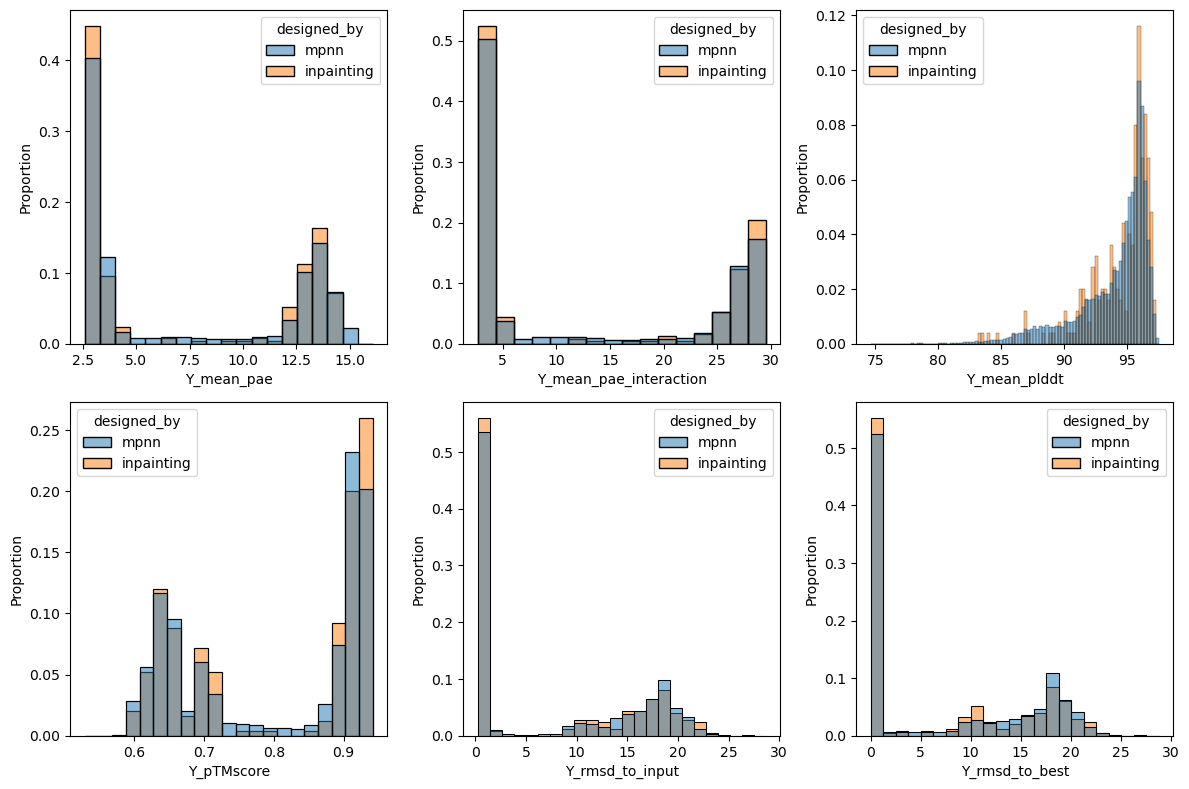

In [4]:
import matplotlib.pyplot as plt
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

cols = [
    "Y_mean_pae",
    "Y_mean_pae_interaction",
    "Y_mean_plddt",
    "Y_pTMscore",
    "Y_rmsd_to_input",
    "Y_rmsd_to_best",
]
the_fig = histplot_df(
    df=scores_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
)
plt.savefig(os.path.join(output_path, "af2_scores_all.png"))

In [5]:
filtered_df = scores_df.query("Y_rmsd_to_input < 3")

In [6]:
filtered_df.parent.value_counts().sort_index()

JHB_07ABr2           43
cs_201r1            112
cs_203r2           1365
cs_207_left        1016
cs_207_right1      1455
cs_207_right2      1510
cs_221              368
cs_230_straight     514
cs_230_twist         64
cs_242              502
cs_243              642
cs_244_straight     372
cs_244_twist        188
cs_245               46
cs_269_straight     432
cs_269_twist        379
cs_287              788
cs_292              982
Name: parent, dtype: int64

6it [00:02,  2.74it/s]


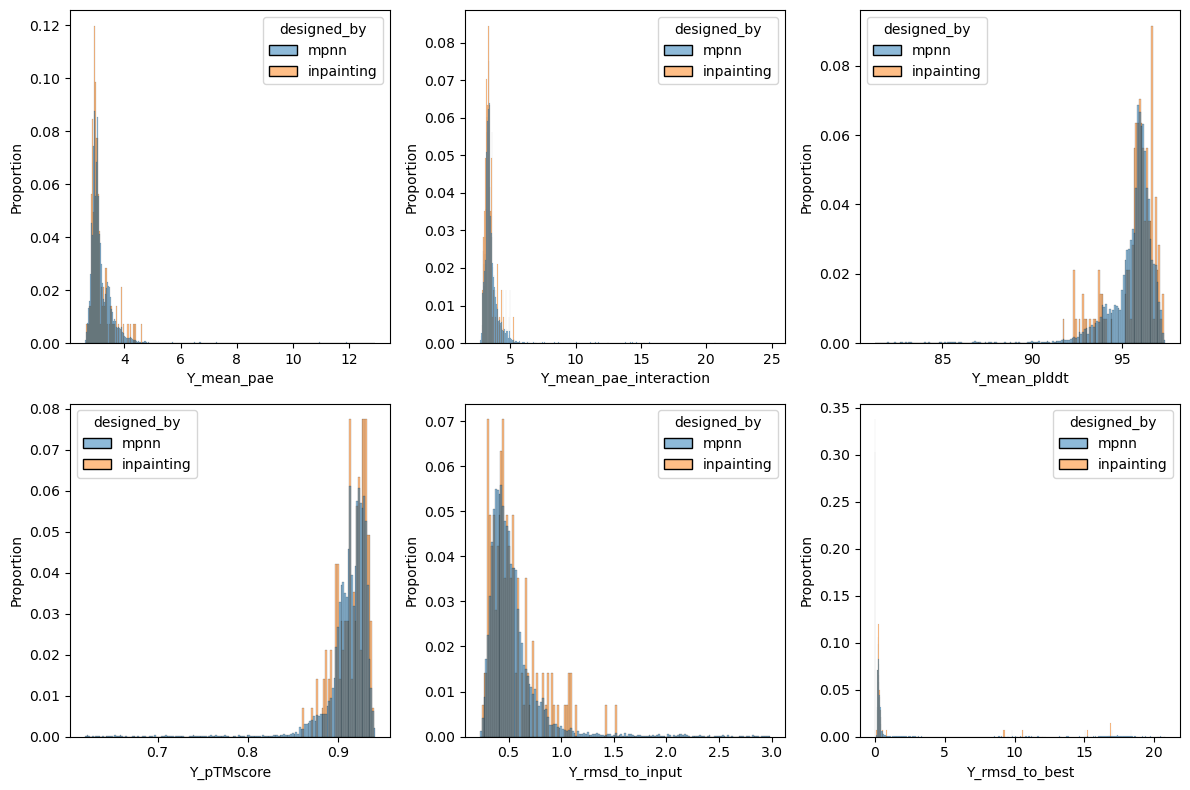

In [7]:
the_fig = histplot_df(
    df=filtered_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
)
plt.savefig(os.path.join(output_path, "af2_scores.png"))

In [8]:
# remove outliers
filtered_df = scores_df.query("Y_mean_pae < 5 and Y_mean_pae_interaction < 6 and Y_mean_plddt > 90 and Y_rmsd_to_input < 2")
len(filtered_df)

10574

In [9]:
filtered_df.parent.value_counts().sort_index()

JHB_07ABr2           43
cs_201r1            111
cs_203r2           1364
cs_207_left         951
cs_207_right1      1446
cs_207_right2      1505
cs_221              368
cs_230_straight     513
cs_230_twist         64
cs_242              430
cs_243              642
cs_244_straight     355
cs_244_twist        188
cs_245               45
cs_269_straight     429
cs_269_twist        379
cs_287              785
cs_292              956
Name: parent, dtype: int64

In [10]:
# get parent pdb path
import pyrosetta.distributed.cluster as cluster
from tqdm.auto import tqdm

for path in tqdm(filtered_df.index):
    pdb_path = cluster.get_scores_dict(path)["instance"]["tasks"]["pdb_path"]
    filtered_df.loc[path, "input_pdb"] = pdb_path

  0%|          | 0/10574 [00:00<?, ?it/s]

/tmp/ipykernel_1449808/2200125767.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[path, "input_pdb"] = pdb_path


In [17]:
import numpy as np
Y_cols = ['Y_mean_pae', 'Y_mean_pae_interaction', 'Y_mean_plddt', 'Y_pTMscore', 'Y_rmsd_to_input']
combined_dict = {}
for input_pdb in filtered_df.input_pdb.unique():
    state_df = filtered_df.query(f"input_pdb == '{input_pdb}'").sort_values("Y_mean_plddt", ascending=False)
    new_row = state_df.iloc[0, :].copy()
    new_row[Y_cols] = state_df[Y_cols].mean()
    y_models = np.sort(state_df.Y_model.unique())
    new_row["Y_models"] = ','.join(y_models.astype(str))
    new_row["num_Y_models"] = len(y_models)
    new_row["Y_paths"] = ','.join(state_df.index)
    combined_dict[state_df.index[0]] = new_row
combined_df = pd.DataFrame.from_dict(combined_dict, orient="index")

6it [00:00, 15.15it/s]


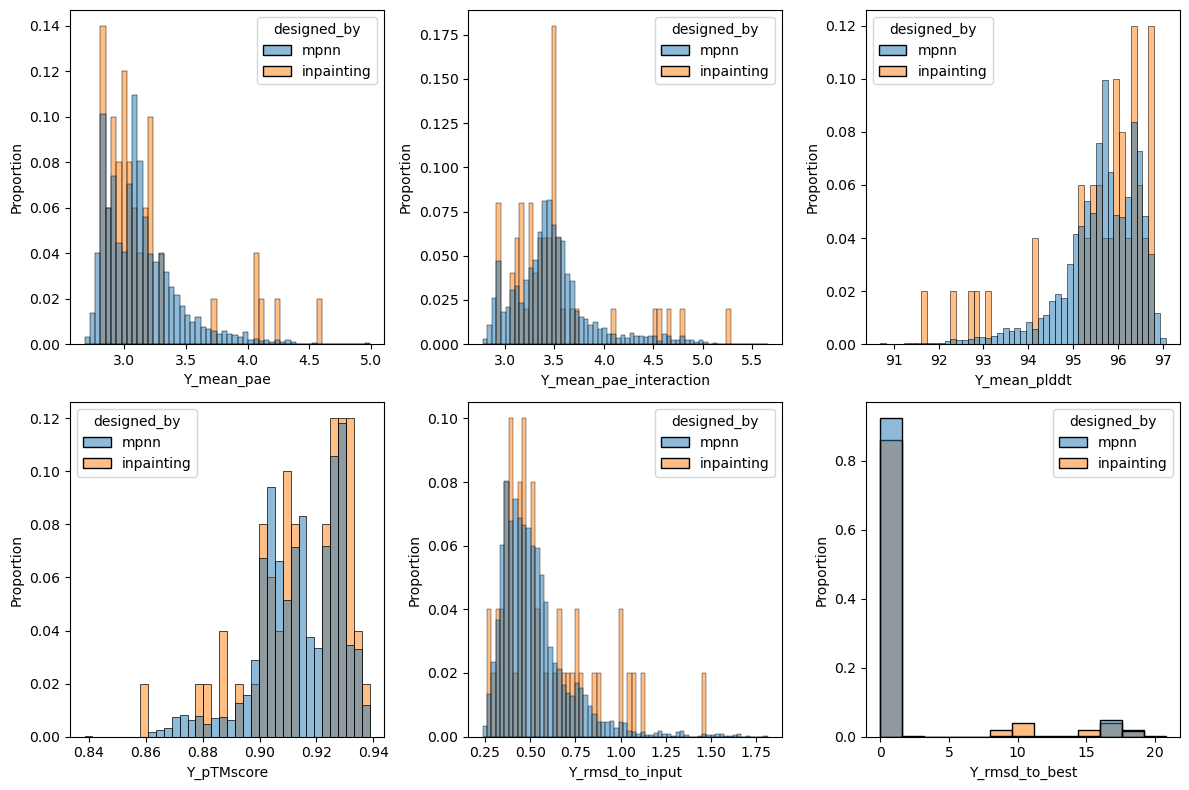

In [18]:
cols = [
    "Y_mean_pae",
    "Y_mean_pae_interaction",
    "Y_mean_plddt",
    "Y_pTMscore",
    "Y_rmsd_to_input",
    "Y_rmsd_to_best",
]
the_fig = histplot_df(
    df=combined_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
)
plt.savefig(os.path.join(output_path, "af2_scores_combined.png"))

In [19]:
def get_len_dab(row):
    dab_contig = row["sampled_mask"].split(';')[1]
    len_dab = 0
    for contig in dab_contig.split(','):
        if contig[0].isalpha():
            start, end = [int(x) for x in contig[1:].split('-')]
            len_dab += end - start + 1
        else:
            len_dab += int(contig.split('-')[0])
    return len_dab

combined_df["len_dab"] = combined_df.apply(get_len_dab, axis=1)
combined_df.sort_values("len_dab", inplace=True, ascending=False)

In [20]:
combined_df.parent.value_counts().sort_index()

JHB_07ABr2          16
cs_201r1            59
cs_203r2           320
cs_207_left        320
cs_207_right1      320
cs_207_right2      320
cs_221             316
cs_230_straight    272
cs_230_twist        28
cs_242             130
cs_243             317
cs_244_straight    120
cs_244_twist        97
cs_245              27
cs_269_straight    319
cs_269_twist       319
cs_287             320
cs_292             319
Name: parent, dtype: int64

In [21]:
combined_df.to_csv(os.path.join(output_path, "scores_combined.csv"))

In [22]:
with open(os.path.join(output_path, "folded_structures.list"), "w") as f:
    for path in combined_df.index:
        print(path, file=f)